# validating_TRecNet.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import sys
sys.path.append("/home/jchishol/TRecNet")
sys.path.append("home/jchishol/")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool
import importlib
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

from training_utilities import PlotLearning

import normalize
import shape_timesteps
import analysis

## Loading Files

In [2]:
# Jet type we want to use
#name = 'e+mjets_train'

# Dataset to train and test on
#dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_parton_'+name+'.h5','r')

# Numpy array of [max,mean] for each variable
#X_maxmean = np.load('X_maxmean_parton_'+name+'.npy')
#Y_maxmean = np.load('Y_maxmean_parton_'+name+'.npy')

# Data type we want to use
data_type = 'variables_ttbar_ljets_6j_train'

# Dataset to train and test on
dataset = h5py.File('/mnt/xrootdg/jchishol/mntuples_08_01_22/'+data_type+'.h5','r')

# Numpy dictionary of [max,mean] for each variable
X_maxmean_dic = np.load('/home/jchishol/TRecNet/X_maxmean_'+data_type+'.npy',allow_pickle=True).item()
Y_maxmean_dic = np.load('/home/jchishol/TRecNet/Y_maxmean_'+data_type+'.npy',allow_pickle=True).item()

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

# Get the maxmean values we actually need for this particular model
xmm_keys = list(X_maxmean_dic.keys())
ymm_keys = [key for key in Y_maxmean_dic.keys() if 'isTruth' not in key and 'ttbar' not in key]
X_maxmean = np.array([X_maxmean_dic[key] for key in xmm_keys])
Y_maxmean = np.array([Y_maxmean_dic[key] for key in ymm_keys])

print(Y_maxmean)

[[ 2.42433750e+03  1.46267823e+02]
 [ 2.36265326e+03 -3.66642000e-01]
 [ 1.61712348e+03 -7.30951782e-01]
 [ 1.07022066e+01  6.54651605e-04]
 [ 2.43950391e+02  1.72247044e+02]
 [ 1.53045374e+03  9.90823212e+01]
 [ 1.45870581e+03 -1.66475415e-01]
 [ 1.28060168e+03 -3.46636355e-01]
 [ 8.92531300e+00  3.70313734e-04]
 [ 2.04917023e+02  8.01318359e+01]
 [ 1.75374163e+03  1.49843150e+02]
 [ 1.41141628e+03  4.59662159e-01]
 [ 1.74988845e+03  9.19522618e-01]
 [ 1.05103025e+01 -7.88349730e-04]
 [ 2.43951250e+02  1.72264233e+02]
 [ 1.54557300e+03  1.04858582e+02]
 [ 1.41250549e+03  4.19614762e-01]
 [ 1.48498035e+03  7.51959860e-01]
 [ 9.10289860e+00 -1.13270234e-03]
 [ 2.03822052e+02  8.01997147e+01]]


## Scale the Data

In [4]:
# Scales data set to be between -1 and 1, with a mean of 0
importlib.reload(normalize)
Scaler = normalize.Scale_variables(phi_keys,dataset,crop0)
X_total, X_names = Scaler.scale_arrays(dataset,X_keys,X_maxmean,crop0)
Y_total, Y_names = Scaler.scale_arrays(dataset,Y_keys, Y_maxmean,crop0)

KeyboardInterrupt: 

## Split Data Into Training, Validation, and Testing

In [11]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
# Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation
split = 70/85   # Gave 85% to train file, now want 70% for the actual training


# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(dataset,X_total, X_names, phi_keys,crop0,False,True)

# Split into training and validation data
trainX_jets, valX_jets, trainX_other, valX_other, trainY, valY = train_test_split(totalX_jets, totalX_other, Y_total, train_size=split)

print(trainY.shape)

## Histograms of Scaled Input X and Y Variables

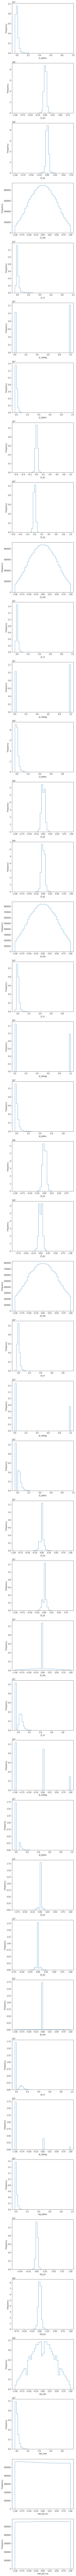

In [16]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

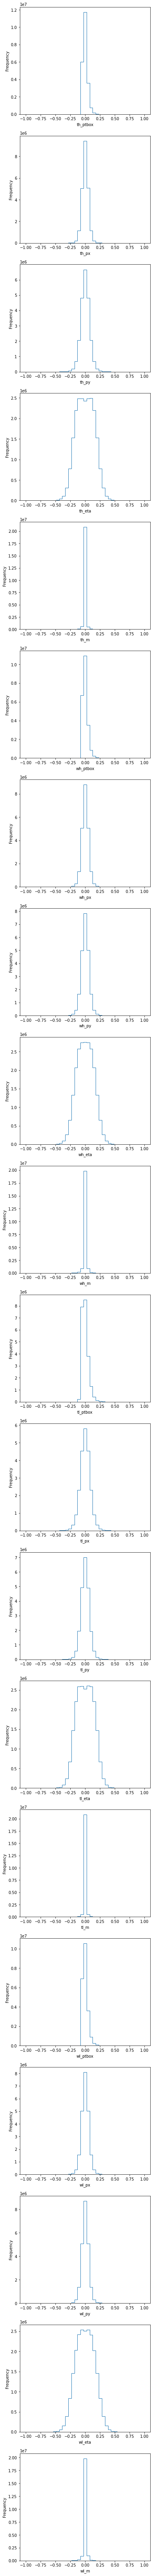

In [17]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

# Load Model

In [5]:
model = keras.models.load_model('Model_Custom_full_6j.keras')
history = np.load('trainHistory_Model_Custom_full_6j.npy',allow_pickle='TRUE').item()

2023-01-26 11:19:40.618949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-01-26 11:19:40.618976: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-26 11:19:40.619224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Validation Data

In [8]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

2022-09-07 11:32:34.234730: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 541.35MiB (rounded to 567652352)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-07 11:32:34.234816: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-09-07 11:32:34.234850: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 49, Chunks in use: 49. 12.2KiB allocated for chunks. 12.2KiB in use in bin. 1.9KiB client-requested in use in bin.
2022-09-07 11:32:34.234869: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.2KiB allocated for chunks. 6.2KiB in use in bin. 6.0KiB client-requested in use in bin.
2022-09-07 11:32:34.234887: 

2022-09-07 11:32:34.235714: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996004500 of size 1024 next 81
2022-09-07 11:32:34.235726: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996004900 of size 512 next 87
2022-09-07 11:32:34.235739: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996004b00 of size 5120 next 28
2022-09-07 11:32:34.235751: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996005f00 of size 256 next 31
2022-09-07 11:32:34.235763: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996006000 of size 256 next 32
2022-09-07 11:32:34.235775: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996006100 of size 1280 next 38
2022-09-07 11:32:34.235787: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996006600 of size 1536 next 29
2022-09-07 11:32:34.235799: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f6996006c00 of size 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ing 5.5KiB
2022-09-07 11:32:34.236991: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 2 Chunks of size 6144 totalling 12.0KiB
2022-09-07 11:32:34.237004: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 6912 totalling 6.8KiB
2022-09-07 11:32:34.237018: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 4 Chunks of size 32768 totalling 128.0KiB
2022-09-07 11:32:34.237031: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 36864 totalling 36.0KiB
2022-09-07 11:32:34.237044: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 2 Chunks of size 44032 totalling 86.0KiB
2022-09-07 11:32:34.237058: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 58880 totalling 57.5KiB
2022-09-07 11:32:34.237071: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 2 Chunks of size 65536 totalling 128.0KiB
2022-09-07 11:32:34.237085: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 69120 totallin

In [ ]:
analysis.Analysis.save_errors(predictions_origscale,true_origscale,Y_keys,True,'Model_Custom_full_Errors')

## Training Scale Plots (Tao's Code)

In [10]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0014775279864906324
 
th_ptbox MSE, MAE :  0.0006325412 0.0169408566
th_px MSE, MAE :  0.0013233210 0.0219179897
th_py MSE, MAE :  0.0010851627 0.0199054361
th_eta MSE, MAE :  0.0047430075 0.0378688516
th_m MSE, MAE :  0.0005993047 0.0087404668
wh_ptbox MSE, MAE :  0.0005891084 0.0154689979
wh_px MSE, MAE :  0.0007902620 0.0169979076
wh_py MSE, MAE :  0.0011912248 0.0208645626
wh_eta MSE, MAE :  0.0071343309 0.0473562260
wh_m MSE, MAE :  0.0010253648 0.0139792443
tl_ptbox MSE, MAE :  0.0004081454 0.0143832691
tl_px MSE, MAE :  0.0007429837 0.0184225107
tl_py MSE, MAE :  0.0006913509 0.0178019301
tl_eta MSE, MAE :  0.0026027866 0.0334057056
tl_m MSE, MAE :  0.0006068589 0.0087803849
wl_ptbox MSE, MAE :  0.0002636707 0.0118075724
wl_px MSE, MAE :  0.0002631855 0.0119005551
wl_py MSE, MAE :  0.0002703225 0.0120969799
wl_eta MSE, MAE :  0.0035872184 0.0420066780
wl_m MSE, MAE :  0.0010004091 0.0137462136


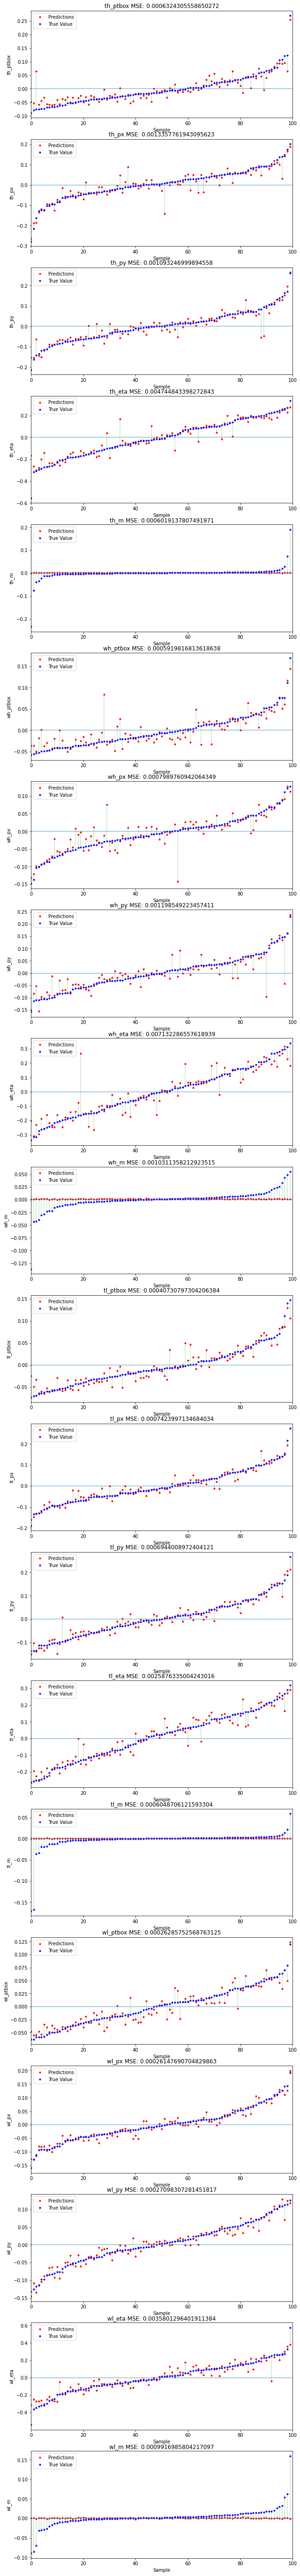

In [15]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

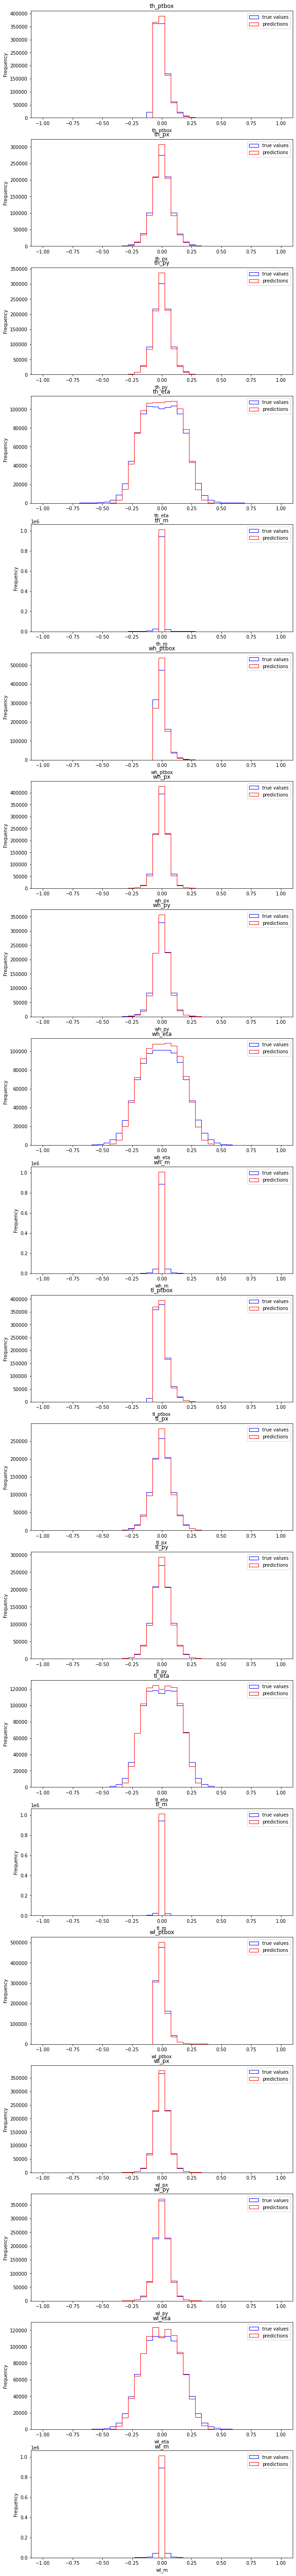

In [16]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

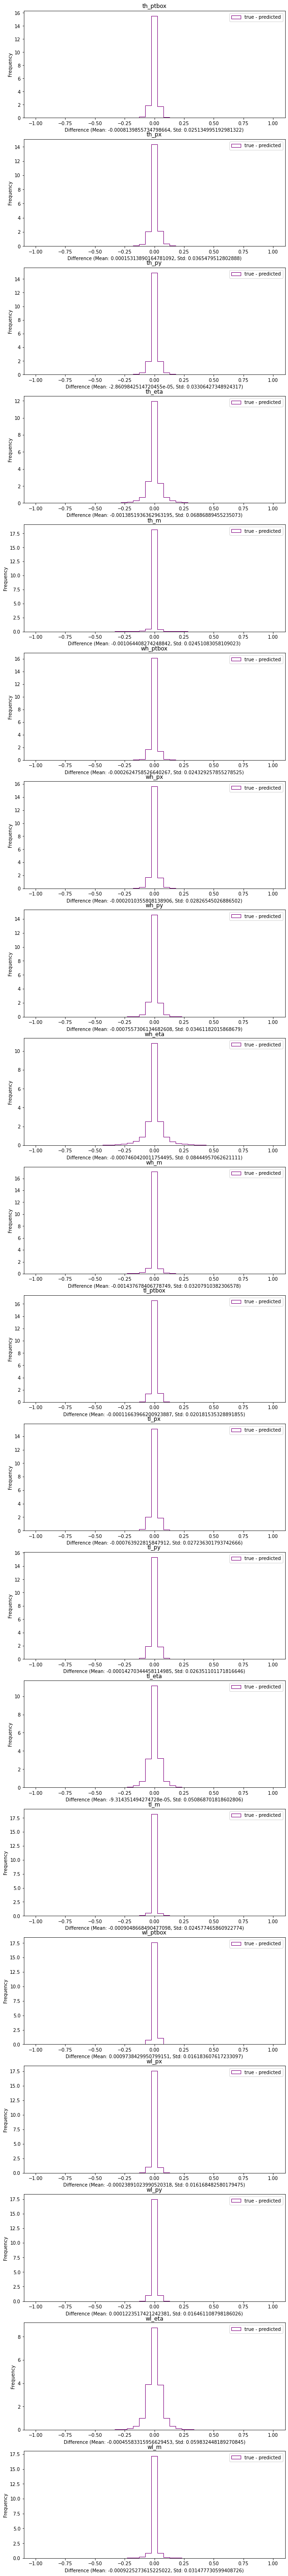

In [17]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

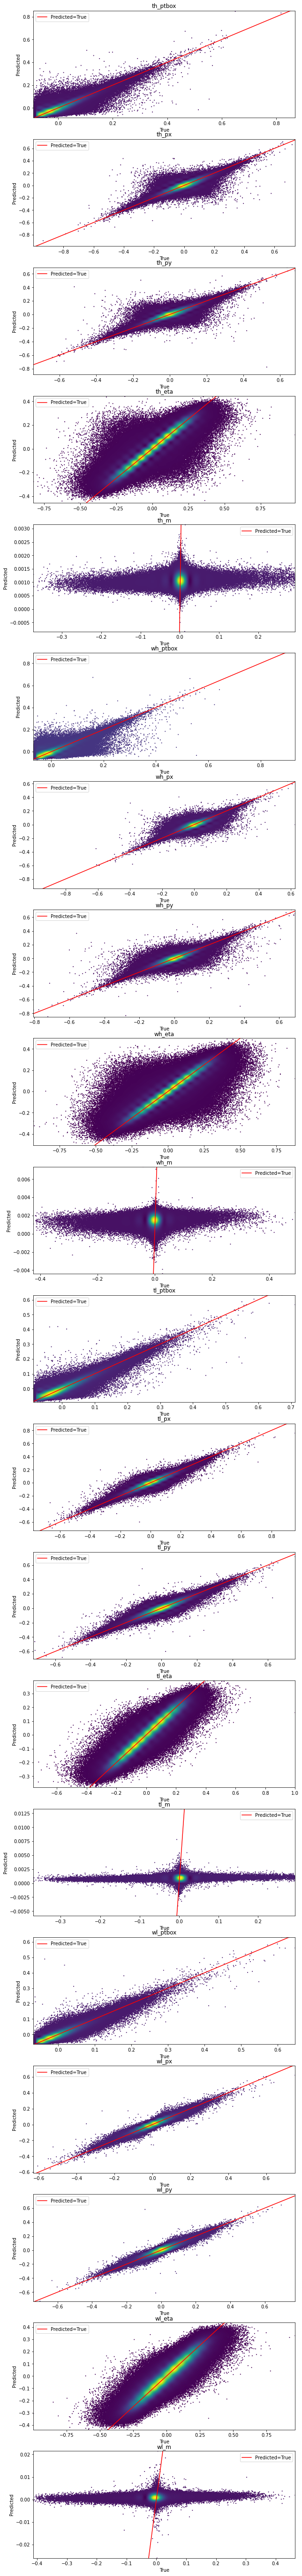

In [18]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [11]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 307.0871486882452
 
th_pt MSE, MAE :  1661.3023214481 27.4546104746
th_eta MSE, MAE :  0.4139491720 0.3537763013
th_phi MSE, MAE :  0.6299425367 0.4286236223
th_m MSE, MAE :  35.6656445466 2.1322386417
wh_pt MSE, MAE :  1260.2241003480 22.6249937376
wh_eta MSE, MAE :  0.4837544709 0.3899536200
wh_phi MSE, MAE :  0.6176645329 0.4405070079
wh_m MSE, MAE :  36.0421030631 2.6208945665
tl_pt MSE, MAE :  1208.3651552956 24.7485198064
tl_eta MSE, MAE :  0.2875206153 0.3511040728
tl_phi MSE, MAE :  0.3839199381 0.3269419576
tl_m MSE, MAE :  36.1155128158 2.1419858835
wl_pt MSE, MAE :  629.8554409882 18.2494650393
wl_eta MSE, MAE :  0.2841410475 0.3738577759
wl_phi MSE, MAE :  0.1835124461 0.2396444339
wl_m MSE, MAE :  37.1725637286 2.6497538321


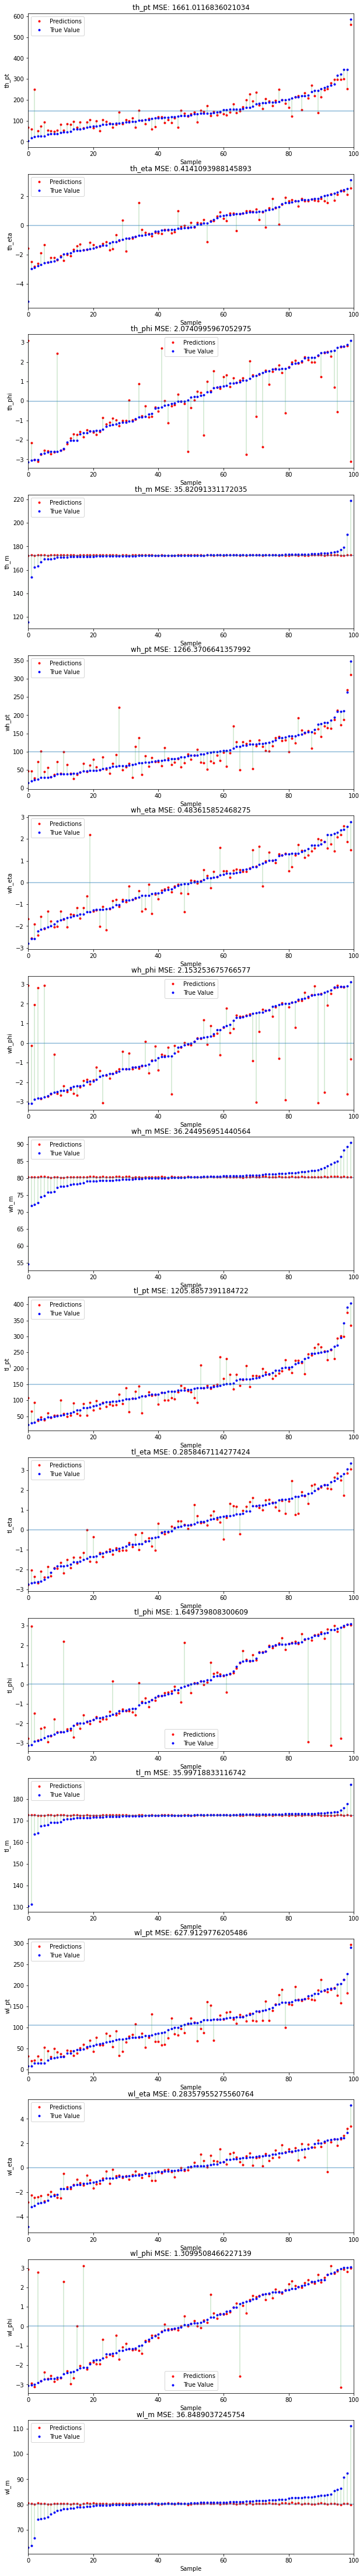

In [20]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

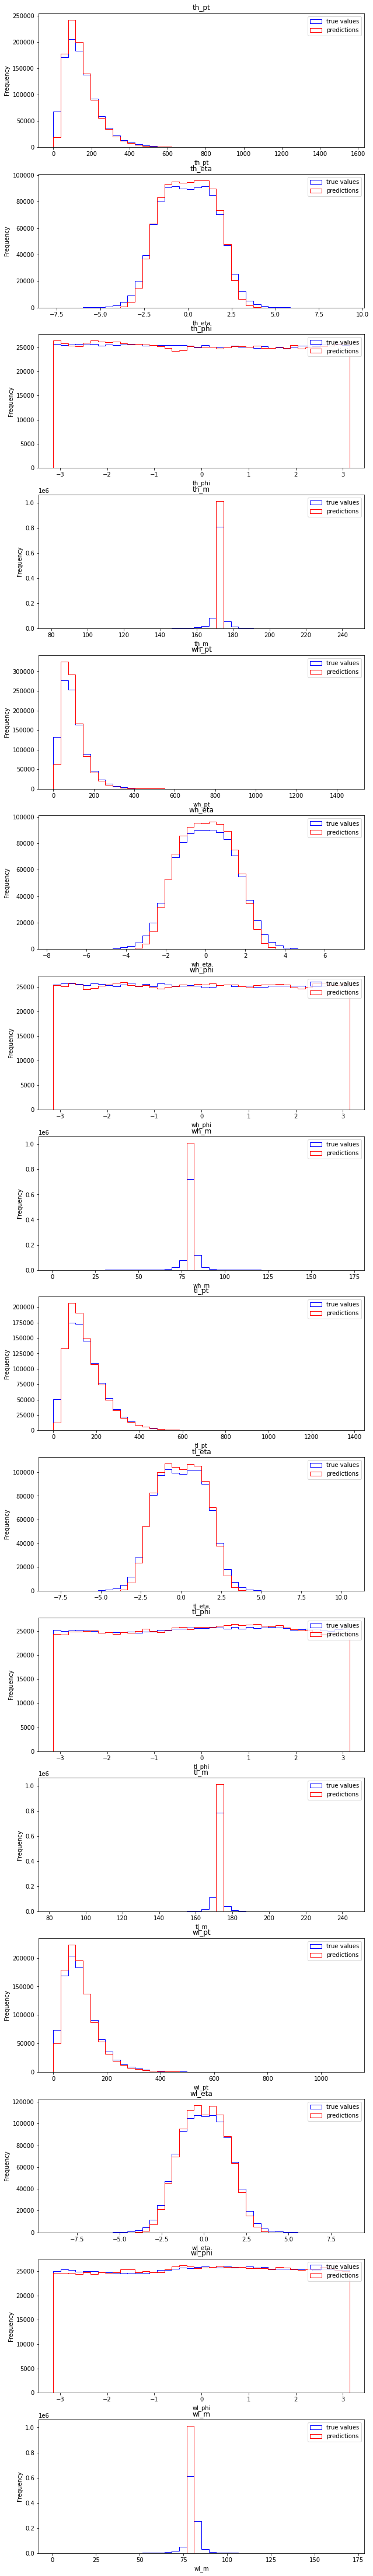

In [21]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


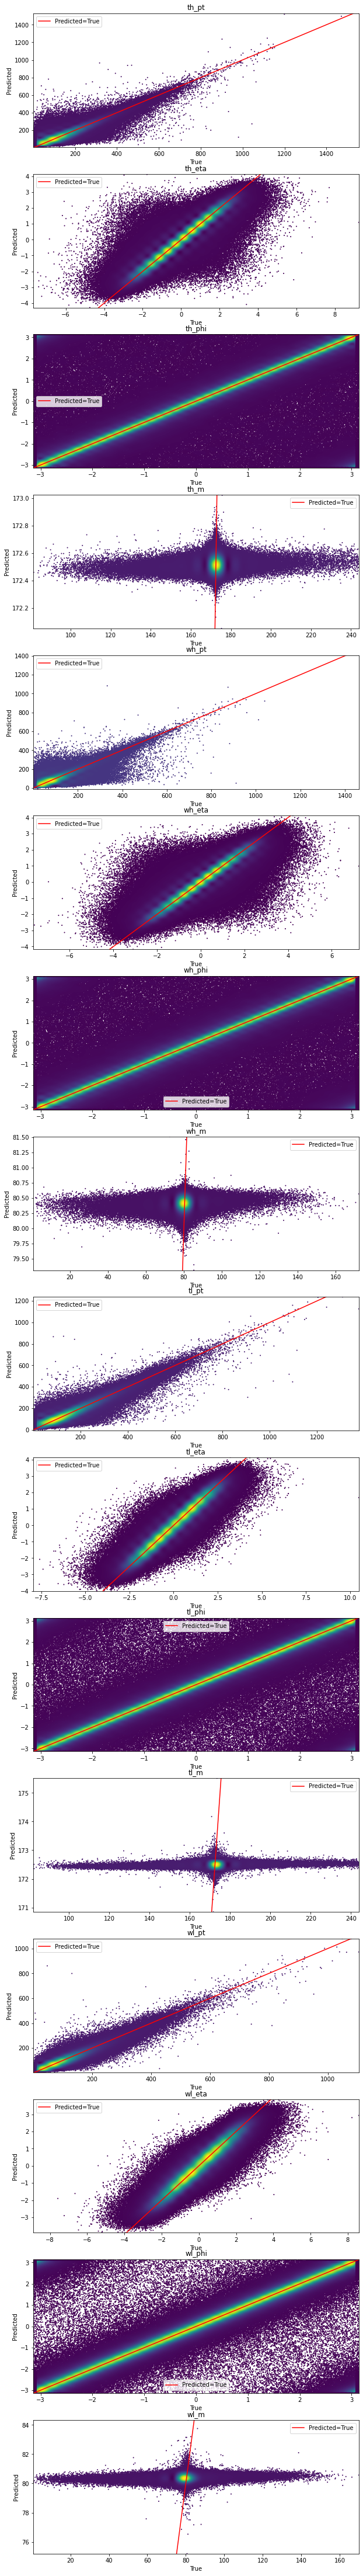

In [22]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

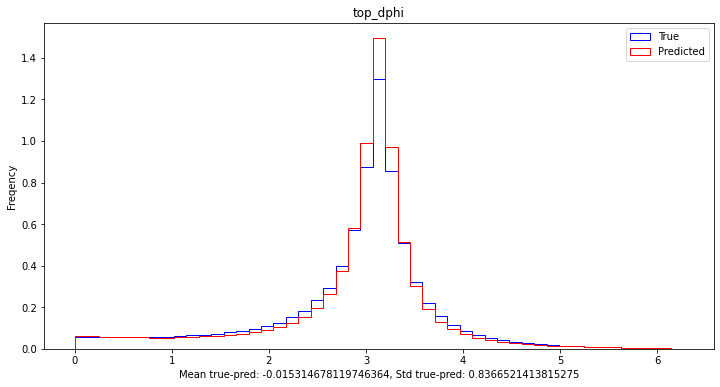

In [23]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

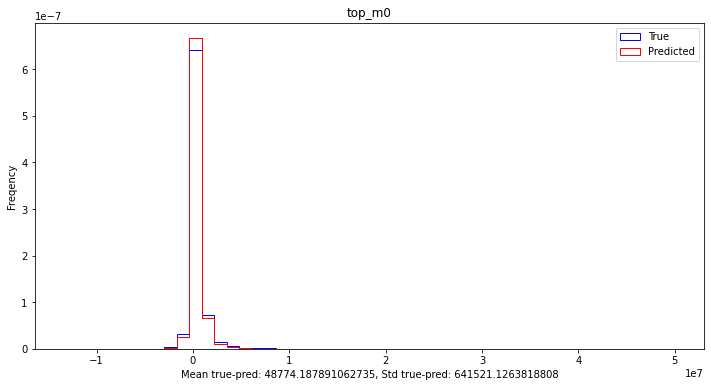

In [24]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

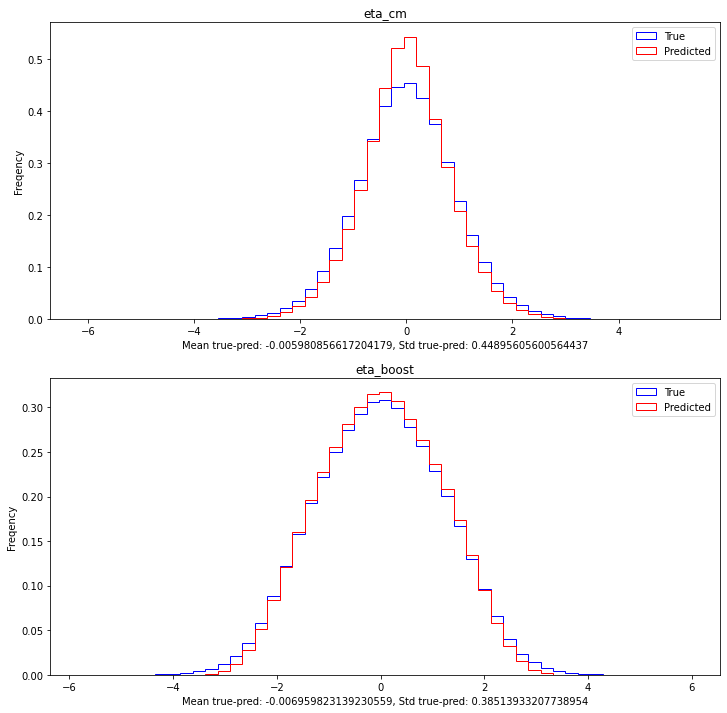

In [25]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

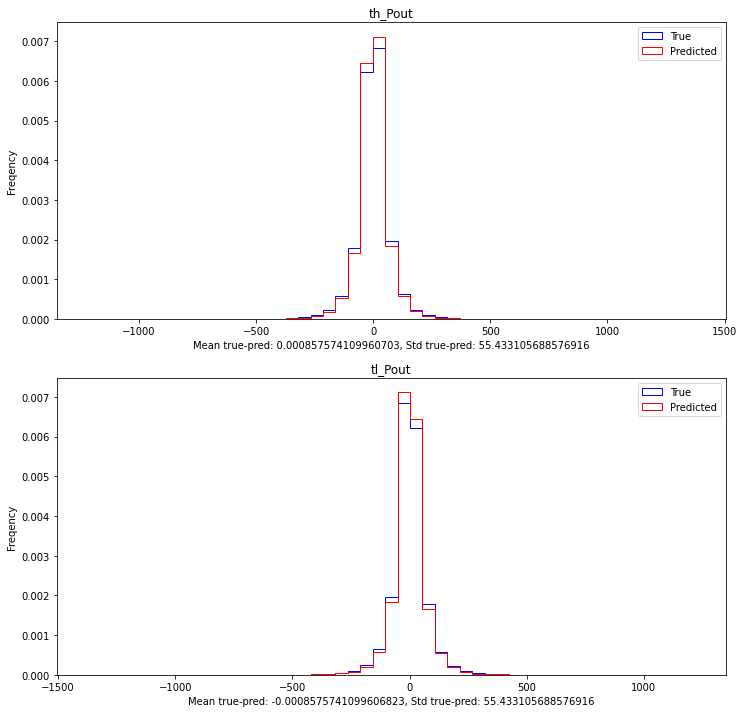

In [26]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

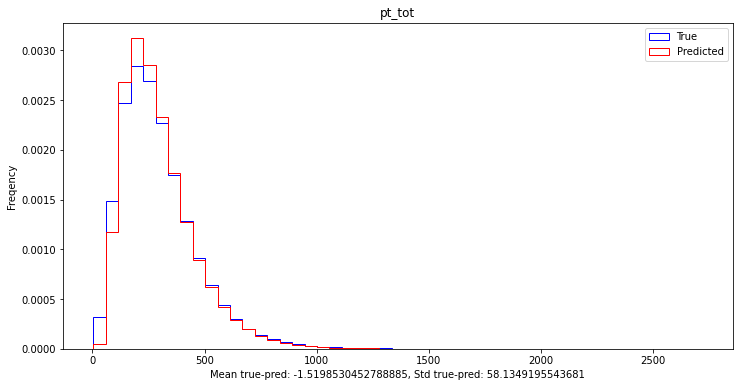

In [27]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])